In [1]:
import pandas as pd
import numpy as np

In [2]:
# Note: This notebook uses blast. To install on MacOS, run `brew install blast`.
# Set this to the location of your Swiss-Prot database
swiss_db_path = "/workspace/blast/swiss/swissprot"
# Maximum length of the IEDB epitopes used
max_epitope_len = 18
# Minimum length of the IEDB epitopes used
min_epitope_len = 9
# Total length of the samples used to create the model. The cleave location is at offset = generated_sample_len/2.
generated_sample_len = 20

data_dir = "/workspace/chipper_data/"
src_dir = "../src/"
models_dir = "../models/"
training_data_dir = data_dir + "training/"
testing_data_dir = data_dir + "testing/"

# Path to IEDB (http://iedb.org/) epitope export file
epitope_csv = training_data_dir + "epitope_table_export_1478815050.csv"
# Paths for models and predictions
LR_model_file = models_dir + "lr.model"
LR_predictions_file = training_data_dir + "LR_predictions.txt"
SVC_model_file = models_dir + "svc.model"
SVC_predictions_file = training_data_dir + "SVC_predictions.txt"

In [3]:
import os, sys, argparse
import subprocess
from itertools import groupby

# https://www.biostars.org/p/710/
def __fasta_iter(fasta_name):
    fh = open(fasta_name)
    # ditch the boolean (x[0]) and just keep the header or sequence since
    # we know they alternate.
    faiter = (x[1] for x in groupby(fh, lambda line: line[0] == ">"))
    for header in faiter:
        # drop the ">"
        header = header.next()[1:].strip()
        # join all sequence lines to one.
        seq = "".join(s.strip() for s in faiter.next())
        yield header, seq

def __create_swiss_prot_dataframe(output_path, swiss_db_path, protein_id_file):
    protein_fasta = output_path + "/" + "proteins.fasta"
    cmd = [
        "blastdbcmd", "-db", swiss_db_path, "-entry_batch", protein_id_file,
        "-out", protein_fasta
    ]
    print " ".join(cmd)
    with open(os.devnull, "w+") as devnull:
        subprocess.call(cmd, stdout=devnull, stderr=subprocess.STDOUT)
    data = []
    for (header, seq) in __fasta_iter(protein_fasta):
        records = header.split('>')
        fields = records[0].split('|')
        header_fields = dict(zip(fields[0::2], fields[1::2]))
        assession_key_exists = False
        assession_keys = ["gb","emb","dbj","sp","ref","pdb"]
        for assession_key in assession_keys:
            if assession_key in header_fields:
                assession_key_exists = True
                break
        if not assession_key_exists:
            print header_fields
            continue
        
        for assession_key in assession_keys:
            try:
                assession = header_fields[assession_key]
                break
            except KeyError:
                continue

        data.append((assession, seq))
    return pd.DataFrame(data, columns=['protein_id', 'protein_sequence'])

# Converts the merged IEDB/Swiss-Prot table into training data [(cleaved_sample, True), (uncleaved_sample, False), ...]
def __create_training_set(output_dir, iedb_swiss_merged, generated_sample_len):
    data = []
    for (protein_id,
         row_ids) in iedb_swiss_merged.groupby("protein_id").groups.items():
        epitope_rows = iedb_swiss_merged.loc[row_ids]
        # Grab the protein sequence from the first row
        protein_sequence = epitope_rows['protein_sequence'].iloc[0]
        # Sort by the C-terminus ('end')
        sorted_epitopes = epitope_rows.sort_values(by="end")
        protein_sequence_len = len(protein_sequence)
        current_loc = 0
        for (i, epitope_sequence, start, end) in \
                sorted_epitopes[["epitope_sequence", "start", "end"]].itertuples():
            epitope_start = int(start) - 1
            epitope_end = int(end) - 1

            half_sample_len = generated_sample_len / 2
            sample_start_end = lambda pos: (pos - half_sample_len + 1, pos + half_sample_len + 1)
            
            epitope_sequence_len = len(epitope_sequence)
            epitope_midpoint = epitope_end - epitope_sequence_len / 2
            
            cleaved_sample_pos = sample_start_end(epitope_end)
            uncleaved_sample_pos = sample_start_end(epitope_midpoint)
            
            # Check if our samples are off the protein sequence or overlap (TODO: handle these)
            if (uncleaved_sample_pos[0] < current_loc or
                    cleaved_sample_pos[1] > protein_sequence_len):
                continue

            current_loc = cleaved_sample_pos[1]

            # Double check that the start and end positions are correct
            assert protein_sequence[epitope_start:epitope_end + 1] == epitope_sequence,\
                     "Epitope failed to align to protein"

            fetch_seq = lambda pos: protein_sequence[pos[0]:pos[1]]
            data.append((fetch_seq(cleaved_sample_pos), 1))
            data.append((fetch_seq(uncleaved_sample_pos), 0))
                        
    cleavage_data = pd.DataFrame(data)
    cleavage_data.columns = ['sequence', 'is_cleaved']
    return cleavage_data


def create_iedb_swiss_dataset(epitope_csv, swiss_db_path, output_dir,
                              max_epitope_len, min_epitope_len,
                              generated_sample_len):
    # Load the CSV from IEDB (skipping the first line, [2:])
    epi = pd.DataFrame.from_csv(epitope_csv)[2:]
    # Rename the columns to remove whitespace
    epi.columns = [
        'type', 'epitope_sequence', 'start', 'end', 'chebi', 'syn', 'protein',
        'protein_id', 'organism', 'oid', 'comments'
    ]
    # Remove GI entries that start with prefix "SRC"
    epi = epi[epi.protein_id.str.startswith("SRC") == False]
    # Remove entries with '+' notation (note: looking into this, e.g. "PLNISLGDVVLY + DEAM(N3)")
    epi = epi[epi.epitope_sequence.str.find('+') == -1]
    # Remove the "GI:" prefix from the GIs provided by IEDB
    epi["protein_id"] = epi.protein_id.str.replace("GI:", "")
    # Drop any epitopes that are not the desired length
    iedb_epitopes = epi[(epi.epitope_sequence.str.len() >= min_epitope_len) \
                         & (epi.epitope_sequence.str.len() <= max_epitope_len)]\
             .loc[:, ["epitope_sequence", "protein_id", "start", "end"]]
    # Create a file with a list of unique protein (antigen) IDs for use with BLAST
    antigen_ids = iedb_epitopes["protein_id"].unique()
    protein_id_file = output_dir + "/" + "protein_ids.txt"
    np.savetxt(protein_id_file, antigen_ids, fmt="%s")
    num_iedb_epitopes = iedb_epitopes.shape[0]
    num_iedb_proteins = antigen_ids.shape[0]
    print "There are %d IEDB MHC-1 epitopes from %d unique proteins (antigens)." % (
        num_iedb_epitopes, num_iedb_proteins)
    swiss_prot_db = __create_swiss_prot_dataframe(output_dir, swiss_db_path,
                                                  protein_id_file)
    print "Found %d IEDB proteins in Swiss-Prot sequence database" % (
        swiss_prot_db.shape[0])
    
    # Merge the IEDB epitops with the SWISS protein data and drop any NaN values (proteins not in SWISSprot)
    iedb_swiss_merged = pd.merge(
        iedb_epitopes, swiss_prot_db, on="protein_id", how="left").dropna()
    # Since we're going to sort on position, convert to numeric columns
    iedb_swiss_merged["start"] = pd.to_numeric(iedb_swiss_merged[
        "start"]).astype(int)
    iedb_swiss_merged["end"] = pd.to_numeric(iedb_swiss_merged["end"]).astype(
        int)
    # Save the raw merged data for reference
    iedb_swiss_merged.to_csv(output_dir + "/" + "merged_iedb_swiss.csv")
    return __create_training_set(output_dir, iedb_swiss_merged, generated_sample_len)

raw_training_data = create_iedb_swiss_dataset(epitope_csv, swiss_db_path, training_data_dir,
                              max_epitope_len, min_epitope_len,
                              generated_sample_len)


/Users/matt/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2881: DtypeWarning: Columns (0,3,4,5,6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


There are 88489 IEDB MHC-1 epitopes from 31164 unique proteins (antigens).
blastdbcmd -db /workspace/blast/swiss/swissprot -entry_batch /workspace/chipper_data/training//protein_ids.txt -out /workspace/chipper_data/training//proteins.fasta
Found 9851 IEDB proteins in Swiss-Prot sequence database


In [4]:
# Read and return the Saxon test set 
def fetch_testing_data():
    df = pd.DataFrame.from_csv(testing_data_dir + "saxova_in_vivo_mhc_1_ligands_dataset.csv")
    df = df[["Sequences", "Activity"]]
    df.columns = ["sequence", "is_cleaved"]
    df.is_cleaved[df.is_cleaved == -1] = 0
    return df

raw_testing_data = fetch_testing_data()
if generated_sample_len != 28:
    # Testing data is 28 residues in length, cut off excess residues
    trim_residues = (28 - generated_sample_len) / 2
    raw_testing_data["sequence"] = raw_testing_data.sequence.str[trim_residues:-trim_residues]

In [5]:
from aa_props import seq_to_aa_props
from sklearn.preprocessing import MinMaxScaler

# We need to remove the Saxova samples from our training set
print "There are %d training samples before removing the Saxova sequences." % (
    raw_training_data.shape[0])
raw_training_data = raw_training_data[raw_training_data.sequence.isin(
    raw_testing_data.sequence) == False]
print "There are %d training samples after filtering out Saxova." % (
    raw_training_data.shape[0])

# Filter to check for selenocysteine (TODO) and an invalid "'"
train_seq_validator = lambda seq: seq.find("U") == -1 and seq.find("'") == -1
# Testing set has two sample which are not the correct len, filter them out too
test_seq_validator = lambda seq: train_seq_validator(seq) and len(seq) == generated_sample_len

process_raw_data = lambda data, is_valid: [(seq_to_aa_props(seq), is_cleaved)
             for (i, seq, is_cleaved) in data.itertuples()
             if is_valid(seq)]

# Filter AA seqs and expand to AA features
training_X_y = process_raw_data(raw_training_data, train_seq_validator)
testing_X_y = process_raw_data(raw_testing_data, test_seq_validator)

(training_X, training_y) = zip(*training_X_y)
(testing_X, testing_y) = zip(*testing_X_y)

# Scale the data
scaler = MinMaxScaler()
training_X = scaler.fit_transform(training_X)
testing_X = scaler.transform(testing_X)

print "Final training set has %d samples of %d raw samples." % (
    training_X.shape[0], raw_training_data.shape[0])
print "Final testing set has %d samples of %d raw samples." % (
    testing_X.shape[0], raw_testing_data.shape[0])


There are 51342 training samples before removing the Saxova sequences.
There are 51314 training samples after filtering out Saxova.
Final training set has 51311 samples of 51314 raw samples.
Final testing set has 416 samples of 419 raw samples.


In [6]:
train_file = training_data_dir + "training_data.ll"
test_file = training_data_dir + "testing_data.ll"

In [7]:
def create_liblinear_files():
    for (outpath, rows) in [(train_file, zip(training_y, training_X)),
                            (test_file, zip(testing_y, testing_X))]:
        with open(outpath, 'w') as out:
            for (is_cleaved, features) in rows:
                out.write("%+d " % (is_cleaved))
                for (feature_id, feature_value) in enumerate(features):
                    out.write("%d:%s " % (feature_id + 1, feature_value))
                out.write("\n")

create_liblinear_files()

In [8]:
# Find the best C parameter for the LR model
LR_findC = !train -C -s 0 $train_file
print "\n".join(LR_findC)

Doing parameter search with 5-fold cross validation.
log2c= -25.00	rate=75.6914
log2c= -24.00	rate=75.9681
log2c= -23.00	rate=77.0205
log2c= -22.00	rate=78.145
log2c= -21.00	rate=79.2618
log2c= -20.00	rate=80.0218
log2c= -19.00	rate=80.5149
log2c= -18.00	rate=80.778
log2c= -17.00	rate=81.0021
log2c= -16.00	rate=81.2789
log2c= -15.00	rate=81.6589
log2c= -14.00	rate=82.2787
log2c= -13.00	rate=83.1186
log2c= -12.00	rate=84.019
log2c= -11.00	rate=84.9428
log2c= -10.00	rate=85.7925
log2c=  -9.00	rate=86.5019
log2c=  -8.00	rate=87.0535
log2c=  -7.00	rate=87.6089
log2c=  -6.00	rate=87.8739
log2c=  -5.00	rate=88.2364
log2c=  -4.00	rate=88.3787
log2c=  -3.00	rate=88.4079
log2c=  -2.00	rate=88.4508
log2c=  -1.00	rate=88.4508
log2c=   0.00	rate=88.4508
log2c=   1.00	rate=88.4508
Best C = 0.25  CV accuracy = 88.4508%


In [9]:
# Find the best C parameter for the SVC model
SVC_findC = !train -C -s 2 $train_file
print "\n".join(SVC_findC)

Doing parameter search with 5-fold cross validation.
log2c= -26.00	rate=77.0264
log2c= -25.00	rate=78.147
log2c= -24.00	rate=79.2657
log2c= -23.00	rate=80.0218
log2c= -22.00	rate=80.5285
log2c= -21.00	rate=80.778
log2c= -20.00	rate=81.0002
log2c= -19.00	rate=81.2769
log2c= -18.00	rate=81.6589
log2c= -17.00	rate=82.3371
log2c= -16.00	rate=83.2141
log2c= -15.00	rate=84.2042
log2c= -14.00	rate=85.2702
log2c= -13.00	rate=86.1082
log2c= -12.00	rate=86.7689
log2c= -11.00	rate=87.3341
log2c= -10.00	rate=87.7862
log2c=  -9.00	rate=88.0805
log2c=  -8.00	rate=88.291
log2c=  -7.00	rate=88.3768
log2c=  -6.00	rate=88.3768
log2c=  -5.00	rate=88.3612
log2c=  -4.00	rate=88.406
log2c=  -3.00	rate=88.406
log2c=  -2.00	rate=88.406
log2c=  -1.00	rate=88.406
Best C = 0.0625  CV accuracy = 88.406%


In [10]:
def create_model_and_predictions(search_output, solver, model_file, predictions_file, probability_estimates):
    # Grab C from the last line...
    bestC = float(search_output[-1].split(" ")[3])
    cmd = "train -c %f -s %d %s %s" % (bestC, solver, train_file, model_file)
    print "> " + cmd
    createModel = !{cmd}
    print "\n".join(createModel)
    cmd = "predict -b %d %s %s %s" % (probability_estimates, test_file, model_file, predictions_file)
    print "> " + cmd
    predict = !{cmd}
    print "\n".join(predict)
    print "\n"

In [11]:
create_model_and_predictions(LR_findC, 0, LR_model_file, LR_predictions_file, 1)
create_model_and_predictions(SVC_findC, 2, SVC_model_file, SVC_predictions_file, 0)

> train -c 0.250000 -s 0 /workspace/chipper_data/training/training_data.ll ../models/lr.model
iter  1 act 4.075e+03 pre 3.561e+03 delta 2.284e+00 f 8.892e+03 |g| 5.304e+03 CG   5
cg reaches trust region boundary
iter  2 act 8.726e+02 pre 7.164e+02 delta 2.938e+00 f 4.816e+03 |g| 1.668e+03 CG   9
cg reaches trust region boundary
iter  3 act 3.026e+02 pre 2.574e+02 delta 3.624e+00 f 3.943e+03 |g| 6.256e+02 CG  11
cg reaches trust region boundary
iter  4 act 1.046e+02 pre 9.626e+01 delta 3.974e+00 f 3.641e+03 |g| 1.916e+02 CG  15
iter  5 act 2.020e+01 pre 1.965e+01 delta 3.974e+00 f 3.536e+03 |g| 7.224e+01 CG  38
> predict -b 1 /workspace/chipper_data/training/testing_data.ll ../models/lr.model /workspace/chipper_data/training/LR_predictions.txt
Accuracy = 77.6442% (323/416)


> train -c 0.062500 -s 2 /workspace/chipper_data/training/training_data.ll ../models/svc.model
iter  1 act 1.841e+03 pre 1.781e+03 delta 1.012e+00 f 3.207e+03 |g| 5.304e+03 CG   5
cg reaches trust region boundary
it

In [12]:
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix

def fetch_LR_probabilities(filepath):
    predictions = []
    with open(filepath, "r") as input:
        for line in input.readlines()[1:]:
            predictions.append(float(line.split(" ")[1]))
    return predictions

def fetch_SVC_predictions(filepath):
    predictions = []
    with open(filepath, "r") as input:
        for line in input.readlines():
            predictions.append(int(line))
    return predictions

SVC_predictions = fetch_SVC_predictions(SVC_predictions_file)
LR_probabilities = fetch_LR_probabilities(LR_predictions_file)

LR_classification_vector = lambda cutoff: [1 if pred >= cutoff else 0 for pred in LR_probabilities]

def find_best_mcc():
    best_mcc = 0.0
    best_cutoff = 0.0
    for i in range(1, 100):
        pred_cutoff = i/100.0
        mcc = matthews_corrcoef(testing_y, LR_classification_vector(pred_cutoff))
        if (mcc > best_mcc):
            best_mcc = mcc
            best_cutoff = pred_cutoff
    return (best_cutoff, best_mcc)

(best_cutoff, best_mcc) = find_best_mcc()
print "** Logistic Regression Report, cutoff= %.2f (MCC=%.3f) **" % (best_cutoff, best_mcc)
print classification_report(testing_y, LR_classification_vector(best_cutoff))

print "** Support Vector Classification Report (MCC=%.3f) ***" % (matthews_corrcoef(testing_y, SVC_predictions))
print classification_report(testing_y, SVC_predictions)

def print_metrics(name, actual, predicted):
    ((tn, fn), (fp, tp)) = confusion_matrix(actual, predicted)
    sensitivity = 100.0 * tp / (tp + fn)
    specificity = 100.0 * tn / (tn + fp)
    precision = 100.0 * tp / (tp + fp)
    print "%s: sensitivity(recall)=%.1f, specificity=%.1f, precision=%.1f" % (name, sensitivity, specificity, precision)

print_metrics("LR", testing_y, LR_classification_vector(best_cutoff))
print_metrics("SVC", testing_y, SVC_predictions)


** Logistic Regression Report, cutoff= 0.35 (MCC=0.620) **
             precision    recall  f1-score   support

          0       0.85      0.75      0.79       208
          1       0.77      0.87      0.82       208

avg / total       0.81      0.81      0.81       416

** Support Vector Classification Report (MCC=0.572) ***
             precision    recall  f1-score   support

          0       0.79      0.78      0.78       208
          1       0.78      0.79      0.79       208

avg / total       0.79      0.79      0.79       416

LR: sensitivity(recall)=77.4, specificity=85.2, precision=87.0
SVC: sensitivity(recall)=78.2, specificity=79.0, precision=79.3


<IPython.core.display.Javascript object>


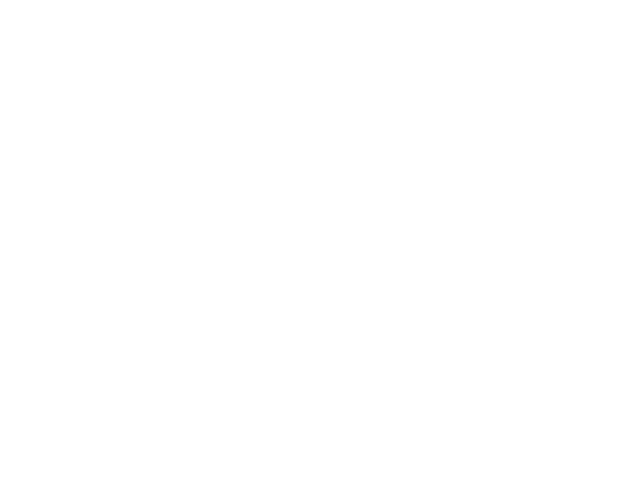

In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn import svm, metrics

fpr, tpr, thresholds = metrics.roc_curve(testing_y, LR_probabilities, pos_label=1)
roc_auc = metrics.roc_auc_score(testing_y, LR_probabilities, average='macro', sample_weight=None)
plt.title('Logistic Regression ROC Curve')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% (roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [14]:
def read_LR_model_weights():
    weights=[]
    with open(LR_model_file, "r") as model:
        for line in model.readlines()[6:]:
            weights.append(float(line))
    return weights

num_hydrophobic_metrics = 18
num_steric_metrics = 17
num_electronic_metrics = 15
num_aa_properties = num_hydrophobic_metrics + num_steric_metrics + num_electronic_metrics

w = read_LR_model_weights()

h_mean = []
h_std = []
s_mean = []
s_std = []
e_mean = []
e_std = []

for chunk in [w[i:i+50] for i in range(0, generated_sample_len * num_aa_properties, num_aa_properties)]:
    start = 0
    end = num_hydrophobic_metrics
    h = chunk[start:end]
    start = end
    end = start + num_steric_metrics
    s = chunk[start:end]
    start = end
    e = chunk[start:]
    h_mean.append(np.mean(h))
    h_std.append(np.std(h))
    s_mean.append(np.mean(s))
    s_std.append(np.std(s))
    e_mean.append(np.mean(e))
    e_std.append(np.std(e))

<IPython.core.display.Javascript object>


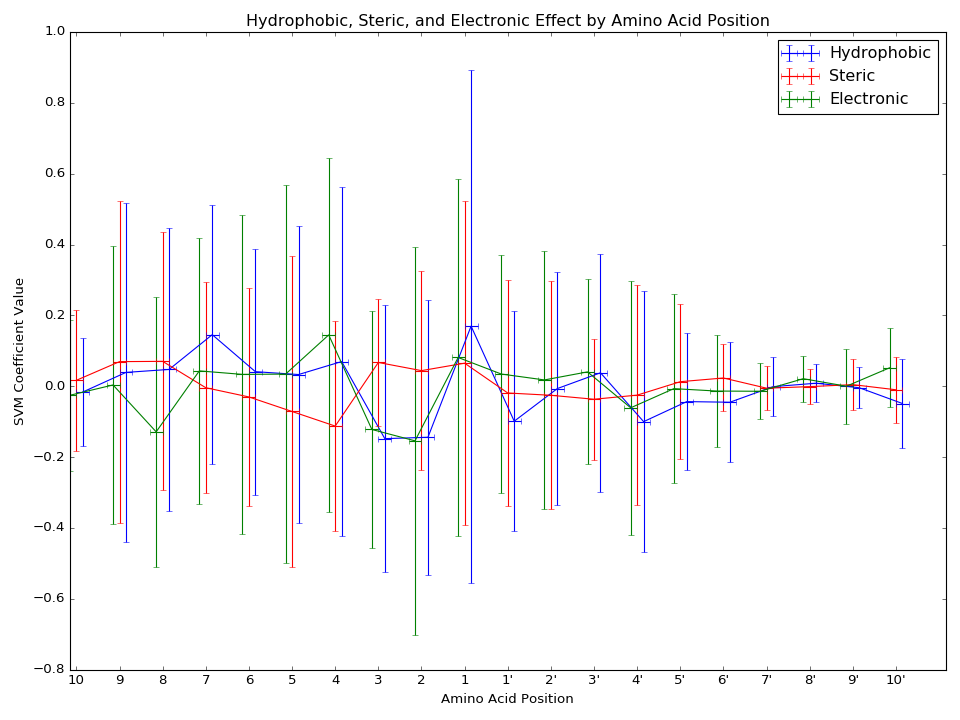

In [15]:
%matplotlib notebook

n_groups = generated_sample_len

fig, ax = plt.subplots(figsize=(12,9))

index = np.arange(n_groups)
bar_width = 0.15

ax1 = ax.errorbar(index + bar_width, h_mean, h_std, bar_width, label="Hydrophobic", color='b')
ax2 = ax.errorbar(index, s_mean, s_std, bar_width, label="Steric", color='r')
ax3 = ax.errorbar(index - bar_width, e_mean, e_std, bar_width, label="Electronic", color='g')

ax.set_xlim(-bar_width,len(index)+bar_width)

plt.xlabel('Amino Acid Position')
plt.ylabel('SVM Coefficient Value')
plt.title('Hydrophobic, Steric, and Electronic Effect by Amino Acid Position')
plt.xticks(index, range (n_groups/2, 0, -1) + [str(i)+"'" for i in range (1, n_groups/2+1)])
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
from sys import stdout as out
from aa_props import all_aa_props

scale = np.array(scaler.scale_[0:50])

scaled_aa_props = {}
for (key, values) in all_aa_props.viewitems():
    scaled_aa_props[key] = np.multiply(scale, values)

def write_aa_props(srcfile, hdrfile):
    generated_warning = """
/*** THIS IS AUTO-GENERATED SOURCE! DO NOT EDIT! ***/
"""
    header_content = """
#ifndef CHIPPER_H_DEFINED
#define CHIPPER_H_DEFINED

#include "linear.h"
#include "output.h"

#define NUM_AA_PROPERTIES 50
#define TRAINING_SET_SIZE %s
#define BEST_CUTOFF_VALUE %.2f
#define BEST_CUTOFF_MCC %.3f
#define GENERATED_SAMPLE_LEN %d
#define NUM_FEATURES (GENERATED_SAMPLE_LEN * NUM_AA_PROPERTIES)

int get_aa_properties(char aa, struct feature_node *features);
int predict_cleavage(const char *fasta_input, const char *output, chipper_output_format format, const char *model_file, int output_probabilities, int cutoff_provided, double cutoff);

#endif
""" % (training_X.shape[0], best_cutoff, best_mcc, generated_sample_len)
    
    with open(hdrfile, 'w') as out:
        out.write(generated_warning + header_content)
     
    aa_props_src_header = generated_warning + """
#include "chipper.h"
#include <stdio.h>
#include <stdlib.h>
#include <string.h>

/* Amino acid properties from https://www.ncbi.nlm.nih.gov/pubmed/15895431
   Scaled to match the current model's input data. */
"""
    aa_props_src_footer = """

int get_aa_properties(char aa, struct feature_node *features) {
    int i;
    int target_aa = aa;
    /* If lowercase, make upper case */
    if ('a' <= target_aa && target_aa <= 'z') {
        target_aa -= ('a'-'A');
    }
    /* Shift to make 'A' equal to zero offset */
    target_aa -= 'A';
    if (0 <= target_aa &&  target_aa <= 25) {
        for(i = 0; i < NUM_AA_PROPERTIES; i++) {
            if (features[i].index == -1) {
                fprintf(stderr, "End of features reached before AA properties for '%c' could be set", target_aa);
                exit(EXIT_FAILURE);
            }
            features[i].value = aa_props[target_aa][i];
        }
        return aa_props[target_aa][0] == -1? 0: NUM_AA_PROPERTIES;
    } else {
        return 0;
    }
}
"""    
    with open(srcfile, "w") as out:
        out.write(aa_props_src_header)
        out.write("static const float aa_props[26][NUM_AA_PROPERTIES] = {\n")
        for key in range(ord('A'), ord('Z')+1):
            out.write("   {")
            try:
                values = scaled_aa_props[chr(key)] 
                out.write(",".join([str(i) for i in values]))
            except KeyError:
                # We scaled our values from zero to one. Mark misses with -1
                out.write(",".join([str(-1) for i in range(0, 50)]))
            out.write("}")
            if key != ord('Z'):
                out.write(",")
            out.write("\n")
        out.write("};")
        out.write(aa_props_src_footer)
        
aa_props_src = src_dir + "aa_props.c"
aa_props_header = src_dir + "chipper.h"
write_aa_props(aa_props_src, aa_props_header)
index_src = !gindent -linux {aa_props_src} {aa_props_header}